In [1]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns #for styling the plots


import geopandas as gpd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import DBSCAN

## Load data

In [ ]:
# family = pd.read_csv('familyGeo.csv')
# hpd_compl = pd.read_csv('hpdcomplaints_byCD_2013to2017.csv')
# nypd_compl = pd.read_csv('nypdcomplaints_byCD_2013to2017.csv')
# race = pd.read_csv('race_geo_clean.csv')
# econ = pd.read_csv('yearly_econ_pct_cd.csv')
# evic = pd.read_csv('yearly_evic_per1000_cd.csv')
# burden = pd.read_csv('yearly_severeburden_pct_cd.csv')

In [2]:
family = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/familyGeo.csv')
# check if we drop totals or %
family_drop = ['Unnamed: 0', 'OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry', 'LocationId', 'Total']
family.drop(columns=family_drop, inplace=True)
family.rename(columns={'BoroCD':'Location', 'Percent':'Family_perc'}, inplace=True)

hpd_compl = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/hpdcomplaints_byCD_2013to2017.csv')
hpd_compl.drop(columns=['Total Number HPD Complaints'], inplace=True)
hpd_compl.rename(columns={'Normalized complaints by population':'hpd_compl_norm', 'boro_cd':'Location', 'year':'Year'}, inplace=True)

nypd_compl = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/nypdcomplaints_byCD_2013to2017.csv')
nypd_compl.drop(columns=['Total Number NYPD Complaints'], inplace=True)
nypd_compl.rename(columns={'Complaints normalized by population':'nypd_compl_norm', 'CD':'Location'}, inplace=True)

race = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/race_geo_clean.csv')
race_drop = ['White', 'Latino', 'Black', 'Asian', 'Other']
race.drop(columns=race_drop, inplace=True)
race.rename(columns={'LocationId':'Location', 'Other':'Race_other', '%Other':'Race_perc_other', '%White':'White_perc', '%Latino':'Latino_perc', '%Black':'Black_perc', '%Asian':'Asian_perc'}, inplace=True)

econ = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/yearly_econ_pct_cd.csv')
econ.drop(columns=['Unnamed: 0', 'Location'], inplace=True)
econ.rename(columns={'Fips':'Location'}, inplace=True)

evic = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/yearly_evic_per1000_cd.csv')
evic.drop(columns=['Unnamed: 0', 'Community District'], inplace=True)
evic.rename(columns={'CD_ID':'Location'}, inplace=True)
evic = evic[['Location', 'Year', 'Evic_rt']]

burden = pd.read_csv('https://raw.githubusercontent.com/JeremyR327/PUI-Cleaned-Data/main/yearly_severeburden_pct_cd.csv')
burden.drop(columns=['Unnamed: 0', 'Location'], inplace=True)
burden.rename(columns={'Fips':'Location'}, inplace=True)

In [3]:
family.head()

Location    Year  Family_perc
0       101  2015.0      0.14185
1       101  2016.0      0.18184
2       101  2013.0      0.16456
3       101  2017.0      0.16096
4       101  2014.0      0.13802

In [4]:
hpd_compl.head()

Location  Year  hpd_compl_norm
0       101  2013        0.000082
1       101  2014        0.008856
2       101  2015        0.020401
3       101  2016        0.018974
4       101  2017        0.014710

In [5]:
nypd_compl.head()

Location  Year  nypd_compl_norm
0       101  2013         0.077536
1       101  2014         0.074896
2       101  2015         0.079816
3       101  2016         0.090065
4       101  2017         0.087868

In [6]:
race.head()

Location  Year  White_perc  Latino_perc  Black_perc  Asian_perc  \
0       101  2013     0.71920      0.06831     0.02233     0.15648   
1       101  2014     0.72273      0.06887     0.02319     0.15057   
2       101  2015     0.71679      0.06837     0.02263     0.15731   
3       101  2016     0.71615      0.06966     0.02227     0.15905   
4       101  2017     0.72039      0.06416     0.02304     0.15709   

   Race_perc_other max_race  
0          0.03368    White  
1          0.03464    White  
2          0.03490    White  
3          0.03288    White  
4          0.03532    White

In [7]:
econ.head()

Year  Location  poverty_pct  unemployment_rt  median_income  \
0  2013       401      0.19033          0.09626    56018.80292   
1  2014       401      0.17129          0.09000    60824.80189   
2  2015       401      0.16715          0.06100    62240.66208   
3  2016       401      0.13800          0.05600    64354.43973   
4  2018       401      0.13941          0.04400    68665.94375   

   limited_english_pct  
0                0.157  
1                0.149  
2                0.154  
3                0.173  
4                0.131

In [8]:
evic.head()

Location  Year    Evic_rt
0       101  2013  43.711095
1       101  2014  35.407584
2       101  2015  28.157475
3       101  2016  26.383320
4       101  2017  22.314438

In [9]:
burden.head()

Year  severe_burden_pct  Location
0  2013            0.19520       101
1  2015            0.18744       101
2  2014            0.18224       101
3  2017            0.16966       101
4  2016            0.17581       101

In [10]:
df = evic.merge(family, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df = df.merge(hpd_compl, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df = df.merge(nypd_compl, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df = df.merge(race, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df = df.merge(econ, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df = df.merge(burden, left_on=['Location', 'Year'], right_on=['Location', 'Year'], how='left')
df

Location  Year    Evic_rt  Family_perc  hpd_compl_norm  nypd_compl_norm  \
0         101  2013  43.711095      0.16456        0.000082         0.077536   
1         101  2014  35.407584      0.13802        0.008856         0.074896   
2         101  2015  28.157475      0.14185        0.020401         0.079816   
3         101  2016  26.383320      0.18184        0.018974         0.090065   
4         101  2017  22.314438      0.16096        0.014710         0.087868   
..        ...   ...        ...          ...             ...              ...   
285       407  2013  63.054351      0.29155        0.000061         0.032104   
286       407  2014  57.068165      0.29129        0.006452         0.032310   
287       407  2015  54.261820      0.26298        0.014570         0.031360   
288       407  2016  48.648503      0.27922        0.013572         0.033090   
289       407  2017  46.482818      0.26578        0.014776         0.033870   

     White_perc  Latino_perc  Black_perc  Asian_perc  Race_perc_other  \
0       0.71920      0.06831     0.02233     0.15648          0.03368   
1       0.72273      0.06887     0.02319     0.15057          0.03464   
2       0.71679      0.06837     0.02263     0.15731          0.03490   
3       0.71615      0.06966     0.02227     0.15905          0.03288   
4       0.72039      0.06416     0.02304     0.15709          0.03532   
..          ...          ...         ...         ...              ...   
285     0.28818      0.17420     0.01910     0.49045          0.02806   
286     0.28154      0.16930     0.01955     0.50286          0.02675   
287     0.27036      0.17063     0.02009     0.51300          0.02591   
288     0.25559      0.17569     0.02142     0.52176          0.02554   
289     0.25665      0.17396     0.02098     0.52635          0.02206   

    max_race  poverty_pct  unemployment_rt  median_income  \
0      White      0.07797          0.04200   137750.63212   
1      White      0.07962          0.04400   129921.14556   
2      White      0.07366          0.04200   131814.92691   
3      White      0.08000          0.03900   146178.73514   
4      White      0.08800          0.02600   151098.52355   
..       ...          ...              ...            ...   
285    Asian      0.16936          0.06918    55502.14599   
286    Asian      0.18822          0.05700    56323.66494   
287    Asian      0.15407          0.04700    54712.82029   
288    Asian      0.15900          0.04200    54381.55772   
289    Asian      0.16200          0.02600    53485.94460   

     limited_english_pct  severe_burden_pct  
0                0.04100            0.19520  
1                0.03700            0.18224  
2                0.03300            0.18744  
3                0.02700            0.17581  
4                0.03162            0.16966  
..                   ...                ...  
285              0.40600            0.34609  
286              0.41500            0.36510  
287              0.41000            0.36301  
288              0.44200            0.37966  
289              0.45917            0.35991  

[290 rows x 17 columns]

In [11]:
df.columns

Index(['Location', 'Year', 'Evic_rt', 'Family_perc', 'hpd_compl_norm',
       'nypd_compl_norm', 'White_perc', 'Latino_perc', 'Black_perc',
       'Asian_perc', 'Race_perc_other', 'max_race', 'poverty_pct',
       'unemployment_rt', 'median_income', 'limited_english_pct',
       'severe_burden_pct'],
      dtype='object')

## Correlation

In [ ]:
# important: choose variables from the corr. output

In [ ]:
#plt.subplots(figsize=(20,13))
#sns.heatmap(df.drop(columns=['Year', 'Location']).corr(), annot=True, linewidths=.1, cmap="YlGnBu")

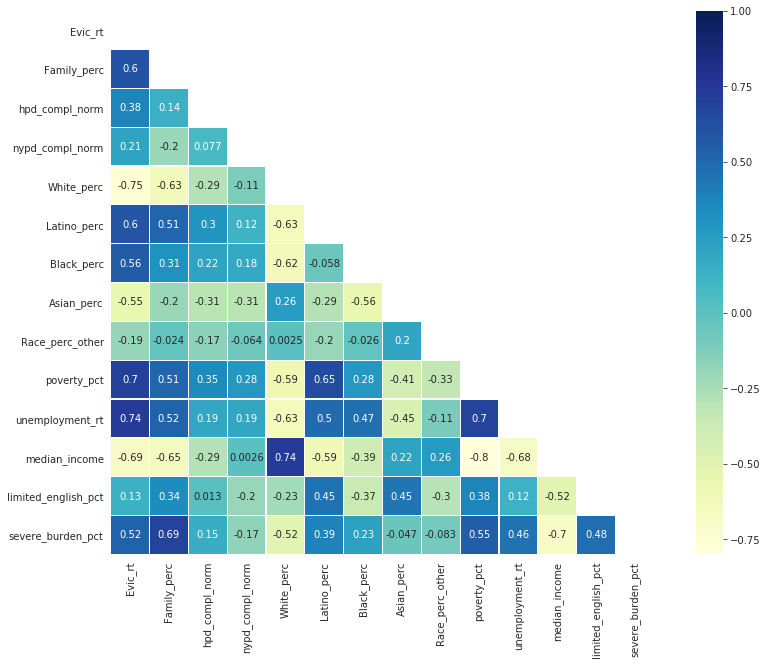

In [13]:
# same eliminating the "duplicated" part of the heatmap

mask = np.zeros_like(df.drop(columns=['Year', 'Location']).corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(df.drop(columns=['Year', 'Location']).corr(), annot=True, linewidths=.1, cmap="YlGnBu", mask=mask, square=True)

## Linear regression

In [ ]:
# to do

In [ ]:
# univariate vs multivariate analysis

In [52]:
# standarize the values

ind_vars = list(df.drop(columns=['Location','Year','Evic_rt', 'max_race']).columns)

standarized = pd.DataFrame()
standarized['Location'] = df['Location']

for var in ind_vars:
    standarized[var] = (df[var] - df[var].mean()) / df[var].std()

standarized['evic_rt_norm'] = (df['Evic_rt'] - df['Evic_rt'].mean()) / df['Evic_rt'].std()
standarized.head()

Location  Family_perc  hpd_compl_norm  nypd_compl_norm  White_perc  \
0       101    -1.475461       -0.811006         0.267654    1.660796   
1       101    -1.758523       -0.580206         0.205190    1.675420   
2       101    -1.717674       -0.276499         0.321582    1.650812   
3       101    -1.291161       -0.314031         0.564064    1.648160   
4       101    -1.513857       -0.426195         0.512076    1.665726   

   Latino_perc  Black_perc  Asian_perc  Race_perc_other  poverty_pct  \
0    -1.129037   -0.894338    0.241495         0.291303    -1.273909   
1    -1.126308   -0.890578    0.191947         0.333991    -1.257611   
2    -1.128745   -0.893026    0.248454         0.345553    -1.316481   
3    -1.122459   -0.894600    0.263042         0.255730    -1.253857   
4    -1.149260   -0.891234    0.246610         0.364229    -1.174837   

   unemployment_rt  median_income  limited_english_pct  severe_burden_pct  \
0        -1.124110       2.604320            -1.108053          -1.378316   
1        -1.066885       2.331921            -1.147170          -1.581730   
2        -1.124110       2.397808            -1.186287          -1.500113   
3        -1.209949       2.897545            -1.244962          -1.682653   
4        -1.581915       3.068711            -1.199782          -1.779181   

   evic_rt_norm  
0     -0.825881  
1     -0.944820  
2     -1.048669  
3     -1.074082  
4     -1.132364

In [ ]:
import statsmodels.formula.api as smf


lm_family = smf.ols(formula='evic_rt_norm~Family_perc', data = standardized).fit()
lm_hdp = smf.ols(formula='evic_rt_norm~hpd_compl_norm', data = standardized).fit()
lm_nypd = smf.ols(formula='evic_rt_norm~nypd_compl_norm', data = standardized).fit()
lm_white =smf.ols(formula='evic_rt_norm~White_perc', data = standardized).fit()
lm_latino =smf.ols(formula='evic_rt_norm~Latino_perc', data = standardized).fit()
lm_black =smf.ols(formula='evic_rt_norm~Black_perc', data = standardized).fit()
lm_asian =smf.ols(formula='evic_rt_norm~Asian_perc', data = standardized).fit()
lm_race_other =smf.ols(formula='evic_rt_norm~Race_perc_other', data = standardized).fit()
lm_poverty =smf.ols(formula='evic_rt_norm~poverty_pct', data = standardized).fit()
lm_unempl =smf.ols(formula='evic_rt_norm~unemployment_rt', data = standardized).fit()
lm_income =smf.ols(formula='evic_rt_norm~median_income', data = standardized).fit()
lm_english =smf.ols(formula='evic_rt_norm~limited_english_pct', data = standardized).fit()
lm_sev_burden =smf.ols(formula='evic_rt_norm~severe_burden_pct', data = standardized).fit()

In [ ]:
list(standardized.drop(columns=['Location','evic_rt_norm']).columns)

In [ ]:
from sklearn.linear_model import LinearRegression

ind_vars = list(standardized.drop(columns=['Location','evic_rt_norm']).columns)

r_squared=[]

for var in ind_vars:
    lm = smf.ols(formula='evic_rt_norm~{}'.format(var),data = df).fit()
    r_squared += [lm.rsquared]

    var_r2 = pd.DataFrame(r_squared, index=ind_vars, columns=['R Squared'])
var_r2

In [ ]:
values = [(lm_family.params[0], lm_family.params[1], lm_family.rsquared),
          (lm_hdp.params[0], lm_hdp.params[1], lm_hdp.rsquared),
          (lm_nypd.params[0], lm_nypd.params[1], lm_nypd.rsquared),
          (lm_white.params[0], lm_white.params[1], lm_white.rsquared)]

columns = ['slope', 'intercept', 'R-squared']
index = ['family','hdp','nypd','white']
            
df = pd.DataFrame.from_records(values, columns = columns)
df.index = index
df

In [ ]:
#obtain values predicted by the regression
df['pred_family']=lm_family.predict()
df['pred_hdp']=lm_hdp.predict()
df['pred_nypd']=lm_nypd.predict()
df['pred_white']=lm_white.predict()

In [ ]:
# visualize results

fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
ax0 = plt.subplot(grid[0, 0])
ax1 = plt.subplot(grid[0, 1])
ax2 = plt.subplot(grid[0,2])
ax3 = plt.subplot(grid[1,0])
ax4 = plt.subplot(grid[1,1])

REStaten_.plot(ax=ax0,kind='scatter',x='GROSS_SQUARE_FEET', y='SALE_PRICE')
ax0.plot(REStaten_['GROSS_SQUARE_FEET'],REStaten_['predicted_price'],'r-');

REStaten_.plot(ax=ax1,kind='scatter',x='LAND_SQUARE_FEET', y='SALE_PRICE')
ax1.plot(REStaten_['LAND_SQUARE_FEET'],REStaten_['pred_price_land'],'r-');

REStaten_.plot(ax=ax2,kind='scatter',x='YEAR_BUILT', y='SALE_PRICE')
ax2.plot(REStaten_['YEAR_BUILT'],REStaten_['pred_price_year'],'r-');

REStaten_.plot(ax=ax3,kind='scatter',x='RESIDENTIAL_UNITS', y='SALE_PRICE')
ax3.plot(REStaten_['RESIDENTIAL_UNITS'],REStaten_['pred_price_ResUnits'],'r-');

REStaten_.plot(ax=ax4,kind='scatter',x='COMMERCIAL_UNITS', y='SALE_PRICE')
ax4.plot(REStaten_['COMMERCIAL_UNITS'],REStaten_['pred_price_ComUnits'],'r-');

plt.show()

## Clustering

In [ ]:
# IMPORTANT: 

#1 standarize everything
#2 how to decide if gm / kmeans / dbscan... 

In [24]:
#df_grouped = df.groupby(by='Location').mean().drop(columns='Year')
#df_grouped.head()

In [54]:
df.columns

Index(['Location', 'Year', 'Evic_rt', 'Family_perc', 'hpd_compl_norm',
       'nypd_compl_norm', 'White_perc', 'Latino_perc', 'Black_perc',
       'Asian_perc', 'Race_perc_other', 'max_race', 'poverty_pct',
       'unemployment_rt', 'median_income', 'limited_english_pct',
       'severe_burden_pct'],
      dtype='object')

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = range(2,10)
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(df.drop(columns=['max_race']))
    #report average Silhouette score
    silhouette_avg = silhouette_score(df.drop(columns=['max_race']), cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.6781691586801532
For n_clusters =3, the average silhouette_score is :0.5463222595119056
For n_clusters =4, the average silhouette_score is :0.5819971367110832
For n_clusters =5, the average silhouette_score is :0.5734419499827051
For n_clusters =6, the average silhouette_score is :0.5839738541954121
For n_clusters =7, the average silhouette_score is :0.5791934896425508
For n_clusters =8, the average silhouette_score is :0.570148891331987
For n_clusters =9, the average silhouette_score is :0.5745437730731793


In [46]:
standarized.head()

Location  Family_perc  hpd_compl_norm  nypd_compl_norm  White_perc  \
0       101    -1.475461       -0.811006         0.267654    1.660796   
1       101    -1.758523       -0.580206         0.205190    1.675420   
2       101    -1.717674       -0.276499         0.321582    1.650812   
3       101    -1.291161       -0.314031         0.564064    1.648160   
4       101    -1.513857       -0.426195         0.512076    1.665726   

   Latino_perc  Black_perc  Asian_perc  Race_perc_other  poverty_pct  \
0    -1.129037   -0.894338    0.241495         0.291303    -1.273909   
1    -1.126308   -0.890578    0.191947         0.333991    -1.257611   
2    -1.128745   -0.893026    0.248454         0.345553    -1.316481   
3    -1.122459   -0.894600    0.263042         0.255730    -1.253857   
4    -1.149260   -0.891234    0.246610         0.364229    -1.174837   

   unemployment_rt  median_income  limited_english_pct  severe_burden_pct  \
0        -1.124110       2.604320            -1.108053          -1.378316   
1        -1.066885       2.331921            -1.147170          -1.581730   
2        -1.124110       2.397808            -1.186287          -1.500113   
3        -1.209949       2.897545            -1.244962          -1.682653   
4        -1.581915       3.068711            -1.199782          -1.779181   

   evic_rt_norm  
0     -0.825881  
1     -0.944820  
2     -1.048669  
3     -1.074082  
4     -1.132364

In [84]:
# nr of clusters
k = 6

# apply clustering to city locations based on activity proportion
gm = GaussianMixture(n_components=k,random_state=324).fit(df.drop(columns=['max_race']))
gm.labels_ = gm.predict(df.drop(columns=['max_race'])) # get labels

result = pd.DataFrame({'Location': df.drop(columns=['max_race']).Location, 'label': gm.labels_}).reset_index(drop=True)
result.head()

Location  label
0       101      1
1       101      1
2       101      1
3       101      1
4       101      1

In [85]:
result.label.unique()

array([1, 0, 2, 5, 4, 3], dtype=int64)

In [86]:
cd = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

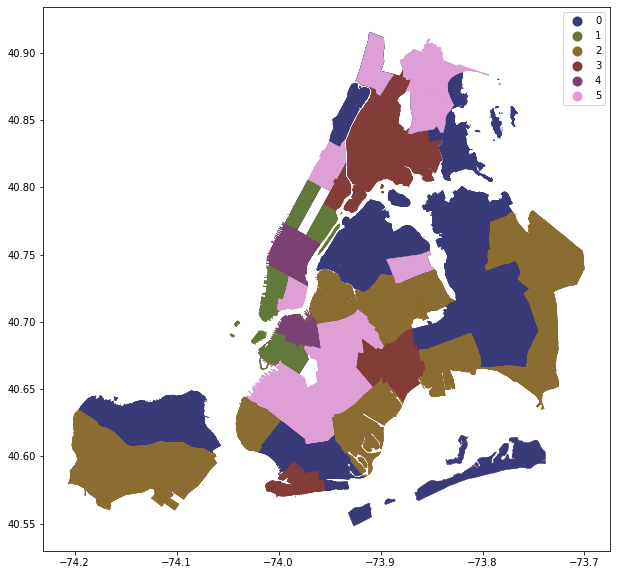

In [87]:
#visualize the clustering together with the categories of each cluster

result['label'] = result['label'].astype(str)
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))

cd.merge(result,left_on='BoroCD',right_on='Location',how='left').plot(column='label',cmap='tab20b', 
                                    legend=True,ax=ax)

In [89]:
cd = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
dfGeo = cd.merge(df,left_on='BoroCD',right_on='Location',how='left')
dfGeo.head()

OBJECTID  BoroCD   Shape__Area  Shape__Length  \
0         1     101  4.268909e+07   74168.382652   
1         1     101  4.268909e+07   74168.382652   
2         1     101  4.268909e+07   74168.382652   
3         1     101  4.268909e+07   74168.382652   
4         1     101  4.268909e+07   74168.382652   

                                            geometry  Location    Year  \
0  MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...     101.0  2013.0   
1  MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...     101.0  2014.0   
2  MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...     101.0  2015.0   
3  MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...     101.0  2016.0   
4  MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...     101.0  2017.0   

     Evic_rt  Family_perc  hpd_compl_norm  ...  Latino_perc  Black_perc  \
0  43.711095      0.16456        0.000082  ...      0.06831     0.02233   
1  35.407584      0.13802        0.008856  ...      0.06887     0.02319   
2  28.157475      0.14185        0.020401  ...      0.06837     0.02263   
3  26.383320      0.18184        0.018974  ...      0.06966     0.02227   
4  22.314438      0.16096        0.014710  ...      0.06416     0.02304   

   Asian_perc  Race_perc_other  max_race  poverty_pct unemployment_rt  \
0     0.15648          0.03368     White      0.07797           0.042   
1     0.15057          0.03464     White      0.07962           0.044   
2     0.15731          0.03490     White      0.07366           0.042   
3     0.15905          0.03288     White      0.08000           0.039   
4     0.15709          0.03532     White      0.08800           0.026   

   median_income  limited_english_pct  severe_burden_pct  
0   137750.63212              0.04100            0.19520  
1   129921.14556              0.03700            0.18224  
2   131814.92691              0.03300            0.18744  
3   146178.73514              0.02700            0.17581  
4   151098.52355              0.03162            0.16966  

[5 rows x 22 columns]

In [90]:
clusters = dfGeo.reset_index().merge(result,left_on='BoroCD',right_on='Location').\
                groupby(['label']).sum().reset_index(drop=True)
clusters

index  OBJECTID  BoroCD   Shape__Area  Shape__Length  Location_x      Year  \
0  74280     16500  126755  6.121181e+10   3.412799e+07    126755.0  725400.0   
1   1695       400    8760  3.530296e+09   4.126334e+06      8760.0  151125.0   
2  50250     11210   84275  5.268193e+10   2.282004e+07     84275.0  443300.0   
3  30850      6750   67050  2.081895e+10   1.358536e+07     67050.0  604500.0   
4   6335      1425   18725  7.017248e+09   6.998726e+06     18725.0  261950.0   
5  50865     11240   95310  2.935464e+10   1.940025e+07     95310.0  735475.0   

        Evic_rt  Family_perc  hpd_compl_norm  ...  Latino_perc  Black_perc  \
0  30651.182431    111.05653        8.256316  ...    111.99119    47.16668   
1   2282.872433     12.92245        1.081007  ...      6.28018     2.21204   
2  11484.589211     67.56956        2.792330  ...     38.88133    41.93591   
3  59247.670298    113.99895       14.809834  ...    160.22605    97.25735   
4   3882.728011     19.07808        2.334775  ...     17.72361     7.85674   
5  39435.772061    114.57883       15.547620  ...     99.90319   132.54848   

   Asian_perc  Race_perc_other  poverty_pct  unemployment_rt  median_income  \
0    72.84942         10.79302     58.34389         26.28117   2.187485e+07   
1     9.93476          2.42735      5.91839          2.87729   9.999300e+06   
2    36.40496          8.99679     27.88132         14.67027   1.699715e+07   
3    11.71325          4.92635    106.65825         36.87185   9.337839e+06   
4    15.88788          4.01317     14.28201          6.02909   1.476962e+07   
5    38.33893          8.18032     86.97889         31.13648   1.821940e+07   

   limited_english_pct  severe_burden_pct  Location_y  
0             72.04698          104.71347      126755  
1              2.60977           13.75965        8760  
2             22.68624           58.45813       84275  
3             64.01865           98.15610       67050  
4              7.12549           25.08499       18725  
5             55.25842          110.20021       95310  

[6 rows x 22 columns]

In [91]:
clusters.shape

(6, 22)

In [92]:
# update from here (old version of col names)
clusters.iloc[:, 8:21].columns

Index(['Family_perc', 'hpd_compl_norm', 'nypd_compl_norm', 'White_perc',
       'Latino_perc', 'Black_perc', 'Asian_perc', 'Race_perc_other',
       'poverty_pct', 'unemployment_rt', 'median_income',
       'limited_english_pct', 'severe_burden_pct'],
      dtype='object')

In [93]:
sel_cols = list(clusters.iloc[:, 8:21].columns)
clusters = clusters[sel_cols]

# normalize values
clusters_norm = clusters.div(clusters.sum(axis=1), axis=0)
clusters_norm['label'] = range(6)
clusters_norm

Family_perc  hpd_compl_norm  nypd_compl_norm  White_perc   Latino_perc  \
0     0.000005    3.774211e-07     7.648316e-07    0.000005  5.119455e-06   
1     0.000001    1.081070e-07     5.252943e-07    0.000005  6.280545e-07   
2     0.000004    1.642782e-07     6.062102e-07    0.000006  2.287464e-06   
3     0.000012    1.585873e-06     2.907058e-06    0.000003  1.715739e-05   
4     0.000001    1.580772e-07     9.700633e-07    0.000006  1.199987e-06   
5     0.000006    8.533177e-07     1.221686e-06    0.000005  5.483100e-06   

     Black_perc    Asian_perc  Race_perc_other   poverty_pct  unemployment_rt  \
0  2.156131e-06  3.330166e-06     4.933815e-07  2.667075e-06     1.201391e-06   
1  2.212169e-07  9.935337e-07     2.427491e-07  5.918734e-07     2.877457e-07   
2  2.467170e-06  2.141774e-06     5.292985e-07  1.640312e-06     8.630803e-07   
3  1.041455e-05  1.254283e-06     5.275255e-07  1.142122e-05     3.948327e-06   
4  5.319449e-07  1.075698e-06     2.717139e-07  9.669714e-07     4.082029e-07   
5  7.274809e-06  2.104199e-06     4.489698e-07  4.773761e-06     1.708899e-06   

   median_income  limited_english_pct  severe_burden_pct  label  
0       0.999965         3.293484e-06           0.000005      0  
1       0.999988         2.609922e-07           0.000001      1  
2       0.999975         1.334675e-06           0.000003      2  
3       0.999918         6.855272e-06           0.000011      3  
4       0.999985         4.824352e-07           0.000002      4  
5       0.999956         3.032811e-06           0.000006      5

Text(0, 0.5, 'variable%')

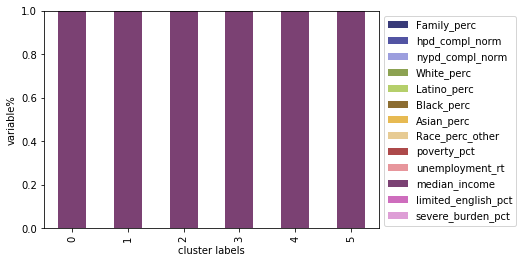

In [94]:
# plot bar

clusters_norm[sel_cols].plot.bar(stacked=True, cmap='tab20b')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.xlabel('cluster labels')
plt.ylabel('variable%')